In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.vocab import GloVe

from nltk.corpus import stopwords

In [3]:
df = pd.read_csv("data/ML_text_data.csv")

In [4]:
df_1 = df[df['discriminatory'] == 1]

In [5]:
df_1

,doc_id,text,discriminatory
1848,2750479,Senate Engrossed adult cabaret performances...,1
1849,2727651,Senate Engrossed state monies; drag shows; ...,1
1850,2773897,House Engrossed Senate Bill state monies; d...,1
1851,2670242,REFERENCE TITLE: public monies; ideology t...,1
1852,2744059,Senate Engrossed public monies; ideology t...,1
...,...,...,...
2655,2758370,As Amended by Senate Committee As Amended by H...,1
2656,2759820,FIRST REGULAR SESSION HOUSE COMMITTEE SUBSTITU...,1
2657,2742094,HOUSE BILL No. AN ACT concerning education; ...,1
2658,2626885,Stricken language would be deleted from and un...,1


In [6]:
bills_too_long = []
for i, row in df_1.iterrows():
    if len(row['text']) > 5000:
        bills_too_long.append(i)
len(bills_too_long)

530

In [7]:
stop_words = set(stopwords.words('english'))

In [8]:
stop_words.update(['.', ',', '(', ')', '--', 'hba', 'sba', 'hb', 'sb', 'house', 'senate', 'session'
                   'hbb', 'sshb', '-ls\\s', '-ls\\a', 'sbb', 'cssb', 'cra', '-ls\\b', 'legislature'])

In [9]:
data_raw = zip(df['discriminatory'], df['text'])

In [10]:
data = [(label, tokens) for (label, tokens) in data_raw] 

In [11]:
len(data)

2660

In [12]:
data_iter = iter(data)
next(data_iter)

(0,
 '  Enrolled HB  LAWS OF ALASKA            Source Chapter No.  CSHB (FIN) _______        AN ACT    Making supplemental appropriati ons and other appropriations; ma king appropriations under  art. IX, sec. (c), Constitution of the State of Alaska, from the constitutional budget reserve  fund; and providing for  an effective date.     _______________     BE IT ENACTED BY THE LEGISLATURE OF THE STATE OF ALASKA:      THE ACT FOLLOWS ON PAGE    -- Enrolled HB                        AN ACT     Making supplemental appropriati ons and other appropriations; ma king appropriations under   art. IX, sec. (c), Constitution of the State of Alaska, from the constitutional budget reserve   fund; and providing for  an effective date.   _______________   (SECTION  OF THIS ACT BEGINS ON PAGE )      CSHB (FIN), Sec.      -  -     * Section . The following appropriation items  are for operating expenditure s from the   general fund or other funds as set out in the fiscal year  budget summary for the   

In [13]:
def clean_text(text):
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = re.sub(" {2,}", " ", text)
    return text

In [14]:
tokenizer = get_tokenizer('basic_english')

In [15]:
for i, (_, text) in enumerate(data_iter):
    text = clean_text(text)
    text = tokenizer(text)
    text = [w for w in text if w not in stop_words]
    print(text)
    if i == 2:
        break

['bill', 'state', 'alaska', 'thirty-third', '-', 'first', 'session', 'representatives', 'wright', 'groh', 'fields', 'mccormick', 'armstrong', 'introduced', '//', 'referred', 'state', 'affairs', 'labor', 'commerce', 'bill', 'act', 'entitled', 'act', 'establishing', 'junet', 'eenth', 'day', 'legal', 'holiday', 'enacted', 'state', 'alaska', '*', 'section', 'amended', 'read', 'following', 'days', 'legal', 'holidays', 'first', 'january', 'k', 'nown', 'new', 'year', "'", 'day', 'third', 'monday', 'january', 'known', 'martin', 'luther', 'king', 'jr', "'", 'birthday', 'provided', 'b', 'section', 'third', 'monday', 'february', 'known', 'presidents', "'", 'day', 'last', 'monday', 'march', 'known', 'seward', "'", 'day', 'last', 'monday', 'may', 'known', 'memorial', 'day', 'th', 'june', 'kno', 'wn', 'juneteenth', 'day', '[', ']', 'fourth', 'july', 'known', 'independence', 'day', '[', ']', 'first', 'monday', 'sep', 'tember', 'known', 'labor', 'day', '[', ']', 'th', 'october', 'known', 'alaska', 'da

In [16]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        text = clean_text(text)
        text = tokenizer(text)
        text = [w for w in text if w not in stop_words]
        yield text

In [17]:
vocab = build_vocab_from_iterator(
    yield_tokens(data), specials=["<unk>"], min_freq=100)

In [18]:
vocab.set_default_index(vocab["<unk>"])

In [19]:
# Checking the result
print(len(vocab))
print(vocab.lookup_token(0))
print(vocab.lookup_token(15))
print(vocab["bill"])
print(vocab["gender"])
print(vocab["pronoun"])
print(vocab["transgender"])

3856
<unk>
provided
58
126
2377
3489


In [20]:
def collate_fn(batch):
    labels = torch.tensor([x[0] for x in batch])
    tokens = [tokenizer(x[1]) for x in batch]
    cbow = [] 
    for t in tokens:
        vec = glove.get_vecs_by_tokens(t)
        indx = [vocab[token] for token in t]
        bow = [0] * len(vocab)
        for i in indx:
            bow[i] = bow[i] + 1/len(tokens)
        cbow.append(bow)
    return labels, torch.tensor(cbow)

In [87]:
class NNClassifier(nn.Module):
    def __init__(self,
                 vocab_size, 
                 hidden_dim1,
                 hidden_dim2, 
                 output_dim,
                 nonlinearity):      
        super(NNClassifier, self).__init__()

        self.linear1 = nn.Linear(vocab_size, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, output_dim)
        self.nonlinearity = nonlinearity
        self.output = nn.Sigmoid()

    def forward(self, word_idxs_batch):
        z = self.linear1(word_idxs_batch)
        h = self.nonlinearity(z)
        z2 = self.linear2(h)
        h2 = self.nonlinearity(z2)
        z3 = self.linear3(h2)
        y = self.output(z3)
        return y.reshape(-1)

In [22]:
import os

In [23]:
cache_dir: str = "CAPP/Adv_ML/.vector_cache"
glove = torchtext.vocab.GloVe('6B', cache=cache_dir)

print(f"Glove embedding files:\
    {os.listdir(cache_dir)} in {os.path.abspath(cache_dir)}")

Glove embedding files:    ['glove.6B.50d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt.pt', 'glove.6B.300d.txt', 'glove.6B.100d.txt', 'glove.6B.zip'] in /home/hemmerly/CAPP/Adv_ML/project/advML_finalProject/CAPP/Adv_ML/.vector_cache


In [88]:
model = NNClassifier(vocab_size = len(vocab),
                     hidden_dim1 = 128,
                     hidden_dim2 =  54,
                     output_dim = 1,
                     nonlinearity = nn.Sigmoid())

In [85]:
loss_function = nn.CrossEntropyLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() 
    log_interval = 10

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label.type('torch.FloatTensor'))
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [81]:
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryPrecision

In [82]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        all_recall = []
        all_precision = []
        recall_metric = BinaryRecall()
        precision_metric = BinaryPrecision()
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            total_acc += (log_probs.round() == label).sum().item()
            total_count += label.size(0)
            recall = recall_metric(log_probs, label)
            precision = precision_metric(log_probs, label)
            all_recall.append(recall)
            all_precision.append(precision)
    accuracy = total_acc/total_count

    return accuracy, np.mean(all_recall), np.mean(all_precision)

In [52]:
# Prep for data split
len_train = int(len(data) * .8)
len_valid = int((len(data) - len_train)/2)
len_test = len(data) - len_train - len_valid
print(len_train, "train", len_valid, "validation", len_test, "testing")

2128 train 266 validation 266 testing


In [53]:
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data, [len_train, len_valid, len_test])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

At iteration 10 the loss is 16.620.
At iteration 20 the loss is 16.605.
At iteration 30 the loss is 13.847.
At iteration 40 the loss is 16.602.
At iteration 50 the loss is 22.158.
At iteration 60 the loss is 16.648.
At iteration 70 the loss is 13.837.
At iteration 80 the loss is 16.582.
At iteration 90 the loss is -0.000.
At iteration 100 the loss is 11.032.
At iteration 110 the loss is 13.692.
At iteration 120 the loss is 13.880.
At iteration 130 the loss is 22.060.
Epoch: 1, time taken: 39.7s, validation accuracy: 0.571, recall: 0.6440476179122925, precision: 0.36778712272644043.
At iteration 10 the loss is 11.070.
At iteration 20 the loss is 5.463.
At iteration 30 the loss is 5.497.
At iteration 40 the loss is 13.667.
At iteration 50 the loss is 8.325.
At iteration 60 the loss is 10.670.
At iteration 70 the loss is 13.835.
At iteration 80 the loss is 10.867.
At iteration 90 the loss is 16.524.
At iteration 100 the loss is 19.173.
At iteration 110 the loss is 13.751.
At iteration 120

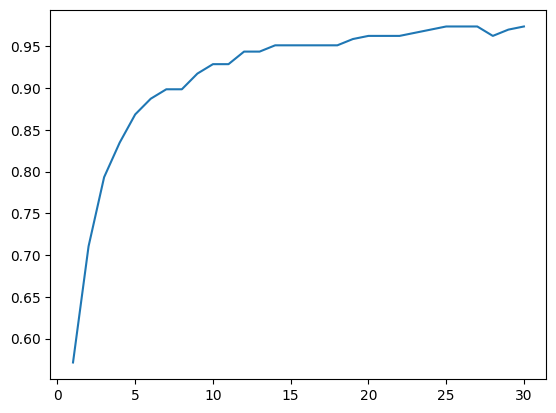

In [54]:
#sigmoid model train
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies=[]
recalls=[]
precisions=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy, recall, precision = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}, recall: {recall}, precision: {precision}.')
    
plt.plot(range(1, EPOCHS+1), accuracies)

accuracy, recall, precision = get_accuracy(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

In [90]:
model = NNClassifier(vocab_size = len(vocab),
                     hidden_dim1 = 128,
                     hidden_dim2 =  54,
                     output_dim = 1,
                     nonlinearity = nn.ReLU())

At iteration 10 the loss is 16.666.
At iteration 20 the loss is 13.785.
At iteration 30 the loss is 5.367.
At iteration 40 the loss is 11.159.
At iteration 50 the loss is 11.127.
At iteration 60 the loss is 13.573.
At iteration 70 the loss is 11.126.
At iteration 80 the loss is 11.330.
At iteration 90 the loss is 13.747.
At iteration 100 the loss is 5.092.
At iteration 110 the loss is 8.454.
At iteration 120 the loss is 16.685.
At iteration 130 the loss is 16.516.
Epoch: 1, time taken: 42.7s, validation accuracy: 0.620, recall: 0.9372548460960388, precision: 0.47155261039733887.
At iteration 10 the loss is 19.050.
At iteration 20 the loss is 7.856.
At iteration 30 the loss is 16.256.
At iteration 40 the loss is 21.699.
At iteration 50 the loss is 24.412.
At iteration 60 the loss is 7.954.
At iteration 70 the loss is 7.718.
At iteration 80 the loss is 13.436.
At iteration 90 the loss is 7.869.
At iteration 100 the loss is 10.598.
At iteration 110 the loss is 5.045.
At iteration 120 the 

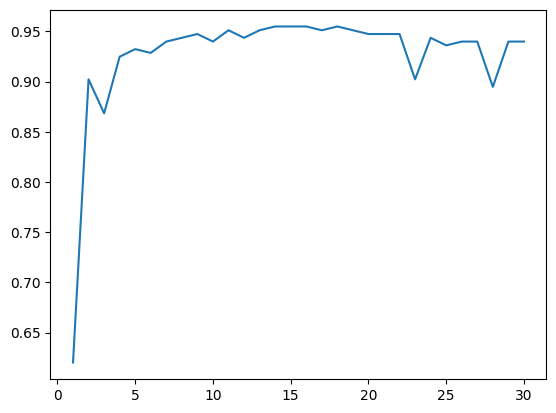

In [91]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies=[]
recalls=[]
precisions=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy, recall, precision = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}, recall: {recall}, precision: {precision}.')
    
plt.plot(range(1, EPOCHS+1), accuracies)

accuracy, recall, precision = get_accuracy(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

In [94]:
model = NNClassifier(vocab_size = len(vocab),
                     hidden_dim1 = 128,
                     hidden_dim2 =  54,
                     output_dim = 1,
                     nonlinearity = nn.ReLU())

In [95]:
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data, [len_train, len_valid, len_test])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

At iteration 10 the loss is 13.861.
At iteration 20 the loss is 16.590.
At iteration 30 the loss is 16.394.
At iteration 40 the loss is 11.064.
At iteration 50 the loss is 19.073.
At iteration 60 the loss is 5.275.
At iteration 70 the loss is 10.811.
At iteration 80 the loss is 13.714.
At iteration 90 the loss is 16.635.
At iteration 100 the loss is 8.189.
At iteration 110 the loss is 13.681.
At iteration 120 the loss is 10.631.
At iteration 130 the loss is 8.262.
Epoch: 1, time taken: 44.6s, validation accuracy: 0.391, recall: 1.0, precision: 0.33508405089378357.
At iteration 10 the loss is 18.906.
At iteration 20 the loss is 13.274.
At iteration 30 the loss is 18.509.
At iteration 40 the loss is 10.756.
At iteration 50 the loss is 13.262.
At iteration 60 the loss is 13.521.
At iteration 70 the loss is 10.394.
At iteration 80 the loss is 24.411.
At iteration 90 the loss is 10.505.
At iteration 100 the loss is 15.870.
At iteration 110 the loss is 10.601.
At iteration 120 the loss is 18

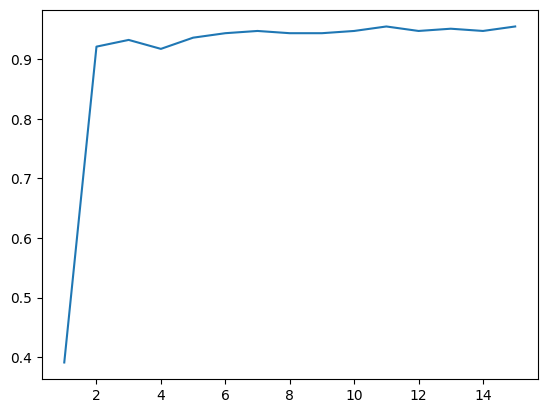

In [96]:
%matplotlib inline

EPOCHS = 15 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies=[]
recalls=[]
precisions=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy, recall, precision = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}, recall: {recall}, precision: {precision}.')
    
plt.plot(range(1, EPOCHS+1), accuracies)

accuracy, recall, precision = get_accuracy(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

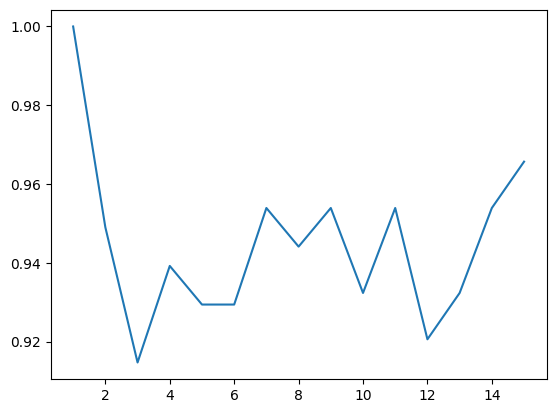

In [97]:
plt.plot(range(1, EPOCHS+1), recalls)

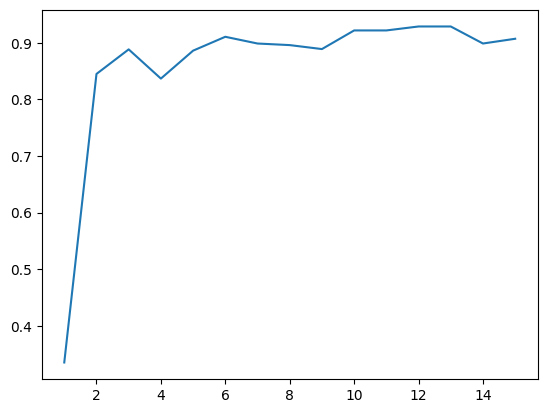

In [98]:
plt.plot(range(1, EPOCHS+1), precisions)